In [1]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for electricity prices and weather measures
from features import electricity_prices, weather_measures 

# We go back into the notebooks folder
%cd notebooks

/Users/tobiasmjensen/Documents/aau_bds/m5_data-engineering-and-mlops/exam_assigment/MLOPs-Assignment-
/Users/tobiasmjensen/Documents/aau_bds/m5_data-engineering-and-mlops/exam_assigment/MLOPs-Assignment-/notebooks


In [2]:
# Importing the packages for the needed libraries for the Jupyter notebook
import pandas as pd
import requests
from datetime import datetime, timedelta

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
# Fetching historical electricity prices for area DK1 from January 1, 2022
# Note: The end date is currently left out to retrieve data up to the present date of yesterday 
# Today is not included in the data as it is not historical data
electricity_df = electricity_prices.electricity_prices(
    historical=True, 
    area=["DK1"], 
    start='2022-01-01', 
    #end='2023-12-31'
)

In [4]:
# Fetching historical forecast of renewable energy data for area DK1 from January 1, 2022
# Note: The end date is currently left out to retrieve data up to the present date of yesterday 
# Today is not included in the data as it is not historical data
forecast_renewable_energy_df = electricity_prices.forecast_renewable_energy(
    historical=True, 
    area = ["DK1"],
    start= '2022-01-01', 
    #end='2023-12-31'
)

In [5]:
# Fetching historical weather measurements from January 1, 2022
# Note: The end date is currently left out to retrieve data up to the present date of yesterday 
# Today is not included in the data as it is not historical data
historical_weather_df = weather_measures.historical_weather_measures(
    historical=True, 
    start = '2022-01-01', 
    #end = '2023-12-31'
)

In [6]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

In [7]:
# Read csv file with calender
calender_df = pd.read_csv('https://raw.githubusercontent.com/Camillahannesbo/MLOPs-Assignment-/main/data/calendar_incl_holiday.csv', delimiter=';', usecols=['date', 'type'])

# Formatting the date column to 'YYYY-MM-DD' dateformat
calender_df["date"] = calender_df["date"].map(lambda x: datetime.strptime(x, '%d/%m/%Y').strftime("%Y-%m-%d"))

In [8]:
# Assuming 'timestamp' is the common column in both DataFrames
merged_df = pd.merge(electricity_df, forecast_renewable_energy_df, on='timestamp', how='inner')
merged_df = pd.merge(merged_df, historical_weather_df, on='timestamp', how='inner')
merged_df = pd.merge(merged_df, calender_df, on='date', how='inner')

# Drop columns 'time_x' and 'date_x'
merged_df = merged_df.drop(['time_x', 'date_x', 'time_y', 'date_y'], axis=1)

# Display the merged DataFrame
merged_df.head()


,timestamp,dk1_spotpricedkk_kwh,dk1_offshore_wind_forecastintraday_kwh,dk1_onshore_wind_forecastintraday_kwh,dk1_solar_forecastintraday_kwh,date,time,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,type
0,1641024000000,0.36930,0.611708,0.236792,0.000050,2022-01-01,2022-01-01 08:00:00,5.7,98.0,0.0,0.0,0.0,3.0,100.0,7.1,13.3,Not a Workday
1,1641027600000,0.52093,0.459708,0.196667,0.004841,2022-01-01,2022-01-01 09:00:00,5.7,99.0,0.0,0.0,0.0,3.0,100.0,4.8,13.3,Not a Workday
2,1641031200000,0.57105,0.310375,0.178500,0.020353,2022-01-01,2022-01-01 10:00:00,6.1,98.0,0.0,0.0,0.0,3.0,100.0,4.7,9.7,Not a Workday
3,1641034800000,0.62541,0.320750,0.201125,0.035719,2022-01-01,2022-01-01 11:00:00,6.3,95.0,0.0,0.0,0.0,3.0,100.0,4.1,9.4,Not a Workday
4,1641038400000,0.70453,0.355667,0.277667,0.038027,2022-01-01,2022-01-01 12:00:00,6.4,95.0,0.0,0.0,0.0,3.0,100.0,8.8,15.5,Not a Workday


In [9]:
merged_df.columns

Index(['timestamp', 'dk1_spotpricedkk_kwh',
       'dk1_offshore_wind_forecastintraday_kwh',
       'dk1_onshore_wind_forecastintraday_kwh',
       'dk1_solar_forecastintraday_kwh', 'date', 'time', 'temperature_2m',
       'relative_humidity_2m', 'precipitation', 'rain', 'snowfall',
       'weather_code', 'cloud_cover', 'wind_speed_10m', 'wind_gusts_10m',
       'type'],
      dtype='object')

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the data in the 'city_name' column
label_encoder.fit(merged_df[['type']])

# Transform the 'city_name' column data using the fitted encoder
encoded = label_encoder.transform(merged_df[['type']])

In [12]:
# Convert the output of the label encoding to a dense array and concatenate with the original data
merged_df = pd.concat([merged_df, pd.DataFrame(encoded)], axis=1)

# Drop columns 'date', 'city_name', 'unix_time' from the DataFrame 'X'
merged_df = merged_df.drop(columns=['date', 'time', 'type', 'timestamp'])

# Rename the newly added column with label-encoded city names to 'city_name_encoded'
merged_df = merged_df.rename(columns={0: "type_encoded"})

In [13]:
merged_df.head()

,dk1_spotpricedkk_kwh,dk1_offshore_wind_forecastintraday_kwh,dk1_onshore_wind_forecastintraday_kwh,dk1_solar_forecastintraday_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,type_encoded
0,0.36930,0.611708,0.236792,0.000050,5.7,98.0,0.0,0.0,0.0,3.0,100.0,7.1,13.3,0
1,0.52093,0.459708,0.196667,0.004841,5.7,99.0,0.0,0.0,0.0,3.0,100.0,4.8,13.3,0
2,0.57105,0.310375,0.178500,0.020353,6.1,98.0,0.0,0.0,0.0,3.0,100.0,4.7,9.7,0
3,0.62541,0.320750,0.201125,0.035719,6.3,95.0,0.0,0.0,0.0,3.0,100.0,4.1,9.4,0
4,0.70453,0.355667,0.277667,0.038027,6.4,95.0,0.0,0.0,0.0,3.0,100.0,8.8,15.5,0


In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14383 entries, 0 to 14382
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   dk1_spotpricedkk_kwh                    14383 non-null  float64
 1   dk1_offshore_wind_forecastintraday_kwh  14367 non-null  float64
 2   dk1_onshore_wind_forecastintraday_kwh   14367 non-null  float64
 3   dk1_solar_forecastintraday_kwh          14367 non-null  float64
 4   temperature_2m                          14383 non-null  float64
 5   relative_humidity_2m                    14383 non-null  float64
 6   precipitation                           14383 non-null  float64
 7   rain                                    14383 non-null  float64
 8   snowfall                                14383 non-null  float64
 9   weather_code                            14383 non-null  float64
 10  cloud_cover                             14383 non-null  fl

In [15]:
X = merged_df.drop('dk1_spotpricedkk_kwh', axis = 1)

In [16]:
y = merged_df['dk1_spotpricedkk_kwh']

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train.head()

,dk1_offshore_wind_forecastintraday_kwh,dk1_onshore_wind_forecastintraday_kwh,dk1_solar_forecastintraday_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,type_encoded
2980,0.501250,1.455500,0.963171,17.3,51.0,0.0,0.0,0.0,1.0,50.0,19.5,45.4,1
6908,0.127417,0.181875,0.000000,-4.3,91.0,0.0,0.0,0.0,0.0,1.0,10.1,16.9,1
13611,0.101333,0.122875,0.000607,3.3,96.0,0.0,0.0,0.0,3.0,100.0,8.9,16.6,1
8104,0.715458,1.969917,1.006710,13.1,73.0,0.0,0.0,0.0,1.0,42.0,14.6,35.3,1
12565,1.047292,2.591708,0.000018,0.6,90.0,0.0,0.0,0.0,3.0,100.0,20.2,37.1,0


In [20]:
import xgboost as xgb

In [21]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor()

# Train the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [23]:
# Predict target values on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("⛳️ MSE:", mse)

# Calculate Root Mean Squared Error (RMSE) using sklearn
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("⛳️ RMSE:", rmse)

# Calculate R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("⛳️ R^2:", r2)

# Calculate Mean Absolute Error (MAE) using sklearn
mae = mean_absolute_error(y_test, y_pred)
print("⛳️ MAE:", mae)

⛳️ MSE: 0.4314049052150694
⛳️ RMSE: 0.6568142090538766
⛳️ R^2: 0.4956415998718591
⛳️ MAE: 0.44461408122163765


In [24]:
import matplotlib.pyplot as plt
import numpy as np

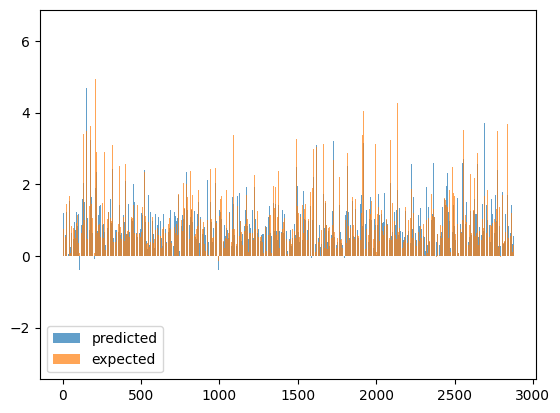

In [25]:
plt.bar(x=np.arange(len(y_pred)), height=y_pred, label='predicted', alpha=0.7)
plt.bar(x=np.arange(len(y_pred)), height=y_test, label='expected', alpha=0.7)
plt.legend()
plt.show() 

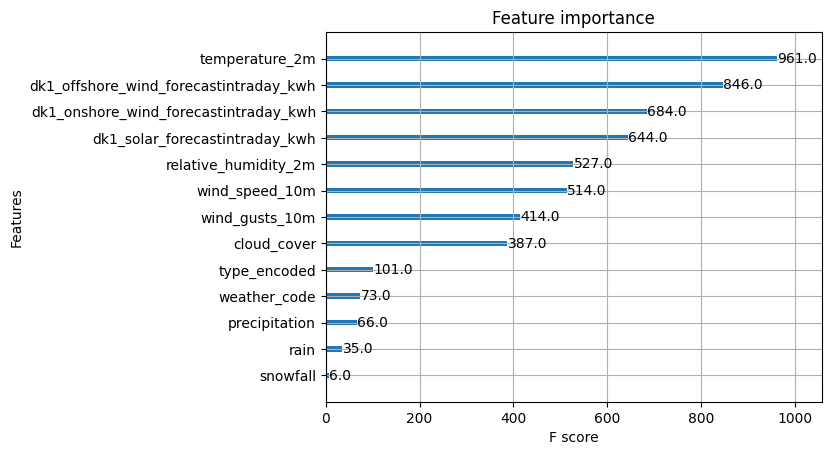

In [26]:
from xgboost import plot_importance
# Plot feature importances using the plot_importance function from XGBoost
plot_importance(
    model, 
    max_num_features=25,  # Display the top 25 most important features
)
plt.show()